# 21M.387 Fundamentals of Music Processing
## Chord Recognition 2

In this lecture, we continue template-based chord detection, but using Hidden Markov Models to improve performance (also known as post-filtering).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
import IPython.display as ipd
import sys
sys.path.append("..")
import fmplib as fmp

plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['image.interpolation'] = 'nearest'
fmp.documentation_button()

## Reading

Chapter 5.3 (pp 273 – 293)

<img src="images/book_cover.png" width=200>

## Introduction

Here we introduce another approach to Chord Recognition based on Hidden Markov Models. This is a more sophisticated analysis approach than just using chord templates. In this context it is sometimes known as a "post filtering" process.

<img src="images/chord_recog_process.png" width=600>

## Markov Chains

### States and Probabilities

<font color='red'>__Whiteboard__</font>: Markov States


A model representing discrete __states__ and the __probabilities__ of transitioning between states.

We define $I$ discrete states:

$$\mathcal{A} = \lbrace \alpha_1, \alpha_2, \dots, \alpha_I \rbrace $$

The model moves from state to state at each time step. All together, we have a __sequence of states__

$$ S = (s_1, s_2, s_3, \dots, s_N) \text{ where } s_n \in \mathcal{A}$$

Next, we define the conditional probability of moving from one state to another state.

$$ a_{ij} = P[s_{n+1} = \alpha_j \lvert s_n = \alpha_i] $$

These $a_{ij}$ coefficients are called __state transition probabilities__ and must adhere to:

$$\sum_{j=1}^I a_{ij} = 1$$

Markov Chains have very bad memory. The current state depends only the previous state and no more.

### Example

We will use the states $\mathcal{A}$ to represent chords. As an example:

- $I = 3$
- $\mathcal{A} = \lbrace \mathbf{C, G, F} \rbrace $
- The $a_{ij}$s are defined below

<img src="images/markov_chain.png" width=500>

Think of this table as a matrix: $\text{From} \times \text{To}$

To complete the model, we need a set of __initial state probabilities__

$$ c_i = P[s_1 = \alpha_i]$$

And, of course:

$$\sum_{i=1}^I c_i = 1$$

In addition to the example values above, let's set:

$$ c_1 = 0.6, c_2 = 0.2, c_3 = 0.2$$

These values can be captured by a matrix $A$ and a vector $C$.

In [2]:
A = np.array( ((.8, .1, .1),(.2, .7, .1),(.1, .3, .6)) )
C = np.array( (.6, .2, .2) )

print('\nA=\n', A)
print('\nC=\n', C)


A=
 [[0.8 0.1 0.1]
 [0.2 0.7 0.1]
 [0.1 0.3 0.6]]

C=
 [0.6 0.2 0.2]


Example State sequence: 
$$S_1 = (\mathbf{C,C,C,G,G,F,F,C,C})$$

It is easy to find the probability of this sequence occurring.

<font color='red'>__Whiteboard__</font>: Sequence Probability

In [3]:
S1 = np.array((0,0,0,1,1,2,2,0,0))
P1 = fmp.markov_sequence_prob(S1, C, A)

print("Sequence:", S1)
print("Probability of Sequence:", P1)

Sequence: [0 0 0 1 1 2 2 0 0]
Probability of Sequence: 0.00012902400000000002


$P[S_1]$ is very small. But this point is to _compare_ the probabilities of _different_ sequences.

For example:
$$S_2 = (\mathbf{F,C,F,C,F,C,F,C,F})$$

In [4]:
S2 = np.array((2,0,2,0,2,0,2,0,2))
P2 = fmp.markov_sequence_prob(S2, C, A)

print("Sequence:", S2)
print("Probability of Sequence: %.10f" % P2)

print("P[S1] / P[S2]:", P1 / P2)

Sequence: [2 0 2 0 2 0 2 0 2]
Probability of Sequence: 0.0000000020
P[S1] / P[S2]: 64511.99999999998


The likelihood of $S_1$ happening is about 65,000 times the likelihood of $S_2$ happening.

### Markov Generator

It is also easy enough to generate a sequence given a Markov Model:
- use a random number generator to generate the initial state.
- use a random number generator to generate the next state given the current state
- repeat

<font color='red'>__Whiteboard__</font>: Sequence Generation

In [5]:
S = fmp.markov_generate(C, A, 17)
print('states:', S)

states: [2 2 1 0 0 2 2 2 1 1 1 0 0 0 1 0 0]


In [6]:
notes = [([60, 67, 65][n]+c, i*.35, .3) for i,n in enumerate(S) for c in (0,4,7)]
chords_snd = fmp.synthesize_sequence(notes, 22050)
ipd.Audio(chords_snd, rate=22050)

## Hidden Markov Models

<font color='red'>__Whiteboard__</font>: HMMs and observation layer

An additional property is added to the model: the _observation layer_.  

- When a state is active, it produces an observation.
- There are a total of $K$ discrete observations possible:
$$\mathcal{B} = \lbrace \beta_1, \beta_2, \dots, \beta_K \rbrace$$
- There is a set of probabilities $b_{ik}$ for state $\alpha_i$ to produce an observation $\beta_k$. And:

$$\sum_{k=1}^K b_{ik} = 1$$

- The underlying Markov model is hidden: we can't directly observe the states.

### Example

In our case:
- The states are chords
- The observations are chroma vectors.
- We can observe the chroma vectors, but we cannot directly observe the underlying chord.

<img src="images/emission_probs.png" width=500>

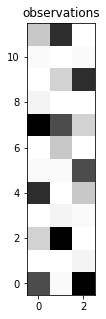

emission probs
 [[0.7 0.  0.3]
 [0.1 0.9 0. ]
 [0.  0.2 0.8]]


In [7]:
b0 = fmp.harmonics_chord_template([0,4,7], 0.7)  # C template
b1 = fmp.harmonics_chord_template([2,7,11], 0.7) # G template
b2 = fmp.harmonics_chord_template([0,5,9], 0.7)  # F template
B_set = np.array((b0, b1, b2))
plt.imshow(B_set.T, origin='lower', cmap='Greys')
plt.title("observations")
plt.show();

B = np.array(( (0.7, 0, 0.3), (.1, .9, 0), (0, 0.2, .8)))
print('emission probs\n', B)

### Discrete States

In general, the actual observation set not may be a finite set. For our chords, chroma vectors are features in $\mathbb{R}^{12}$ - an infinite set. Some fancier HMMs are _continuous HMMs_ where $B$ is described by _probability density functions_. We use _discrete HMMs_ as follows:

- Create a _codebook_ of finite observations.
- This can be done by hand or can be learned by using a clustering algorithm.
- Create a mapping process between actual observations and the codebook set (a.k.a _quantization_)

## Formal Definition of the Model

- $I$ discrete states:
$$\mathcal{A} = \lbrace \alpha_1, \alpha_2, \dots, \alpha_i \rbrace $$
- $A$ = ($I \times I$) matrix of transition probabilities
- $C$ = length $I$ vector of initial probabilities
- $K$ discrete observations:
$$\mathcal{B} = \lbrace \beta_1, \beta_2, \dots, \beta_k \rbrace$$
- $B$ = ($I \times K$) matrix of emission probabilities

These 5 parameters define the entire HMM:  
$$\Theta = (\mathcal{A}, A, C, \mathcal{B}, B)$$

- $\mathcal{A}$ and $\mathcal{B}$ are fixed.
- $A, C, B$ are free parameters that need to be determined somehow.

## HMM as a generator

Given the HMM mode $\Theta = (\mathcal{A}, A, C, \mathcal{B}, B)$, it is easy enough to generate an observation sequence:

$$O = (o_1, o_2, \dots , o_N)$$

For example, let's create a sequence of 20 observations based on the example model.

In [8]:
S, O = fmp.hmm_generate(C, A, B, 20)
print('states:', S)
print('observ:', O)

states: [1 1 1 2 2 2 2 2 2 1 1 1 0 0 0 0 2 2 1 1]
observ: [1 1 1 2 2 2 2 2 2 1 1 1 0 2 0 0 2 2 1 1]


## HMM Problem Formulations

Our problem is the reverse. We are given $O$, and need to find the underlying hidden states that "best explain" $O$ given model parameters $\Theta$.

There are three problems generally solvable with the HMM structure:
- Evaluation Problem: Given $O$ and $\Theta$, what is the probably of $O$?
- Estimation Problem: Given $O$, what are the model parameters $A,C,B$?
- Uncovering Problem: Given $O$ and $\Theta$, what state sequence $S$ best explains $O$? 

We are interested in the last problem.

## The Viterbi Algorithm

Given $O$ with $N$ observations:  
The problem is to find the "best" or "highest-scoring" or "most likely" sequence $S^*$ from all possible sequences of length $N$.

The Viterbi algorithm is a dynamic programming algorithm applied to HMMs. See page 284 in the text book for a deeper explanation

<img src="images/viterbi.png" width=500>

### Viterbi Example

<img src="images/viterbi_toy.png" width=600>

## Application to Chord Recognition

### Hidden states
States $\mathcal{A} = \lbrace \text{12 major and 12 minor chords} \rbrace$. $I=24$

### Observations Codebook

- We define a codebook of $K=24$ output states.
- Instead of using a learning algorithm, simply use the 24 template vectors with a suitable value for $\alpha$, the decay parameter.

$\mathcal{B}$ is:

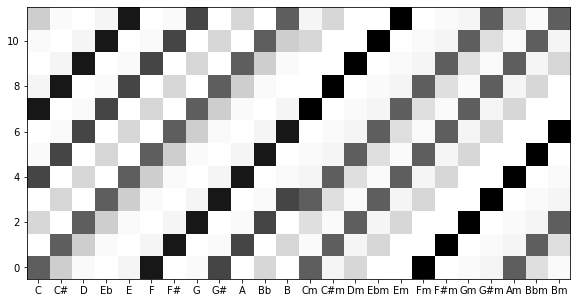

In [9]:
triads = fmp.make_triads_templates(0.7)
plt.imshow(triads.T, origin='lower', cmap='Greys')
fmp.chord_template_labels(1)

- To map a real observation to the codebook, find the closest match using the dot product.

This is exactly the same procedure as the template matching algorithm from before.

Example, an observation from _Let It Be_:

In [10]:
# Test case with beatles
snd1 = fmp.load_wav("audio/beatles_let_it_be.wav",0,30)
fs = 22050.
ipd.Audio(snd1[0:int(fs*5)], rate=fs)

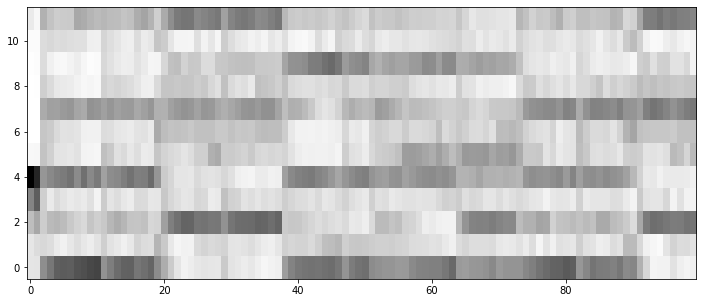

In [11]:
fft_len = 4096
hop_size = fft_len // 2
ff = fs / hop_size
chroma = fmp.make_chromagram(snd1, fs, fft_len, hop_size, gamma=1.0)
plt.imshow(chroma[:,0:100], origin='lower', aspect='auto', cmap="Greys");

Pick an example chroma vector at 2 seconds ($n=22$)

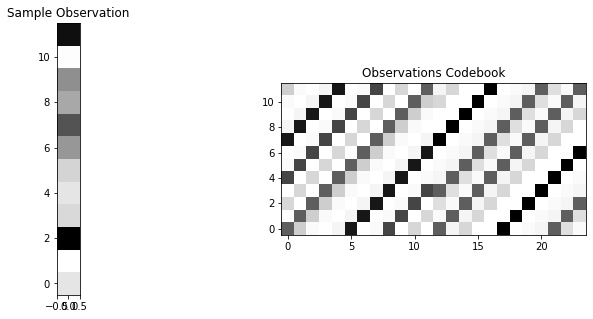

In [12]:
ex_obs = chroma[:,22]

plt.subplot(1,2,1)
plt.imshow(np.atleast_2d(ex_obs).T, origin='lower', cmap='Greys')
plt.title("Sample Observation")
plt.subplot(1,2,2)
plt.imshow(triads.T, origin='lower', cmap='Greys')
plt.title("Observations Codebook")
plt.show()


best match: 7


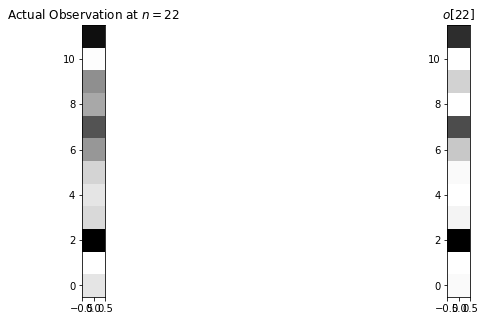

In [13]:
scores = np.dot(triads, ex_obs)
match = np.argmax(scores)
print('best match:', match)

plt.subplot(1,2,1)
plt.title("Actual Observation at $n=22$")
plt.imshow(np.atleast_2d(ex_obs).T, origin='lower', cmap='Greys')
plt.subplot(1,2,2)
plt.title("$o[22]$")
plt.imshow(np.atleast_2d(triads[match]).T, origin='lower', cmap='Greys')
plt.show()


### Transition Probabilities

How to create matrix $A$?

In music, some transitions are more likely than others.
- $C \rightarrow G$ is more likely than $C \rightarrow F \sharp$
- $C \rightarrow C$ (_self-transition_ probabilities) should always be high.

Options:
- Can create $A$ by hand using expert musical knowledge and knowledge of style / genre.
- Can learn $A$ by using labeled observations

We will use the simplest possible hand-constructed matrix for $A$:
- high values along the diagonal (self-transition)
- low values everywhere else

For example:

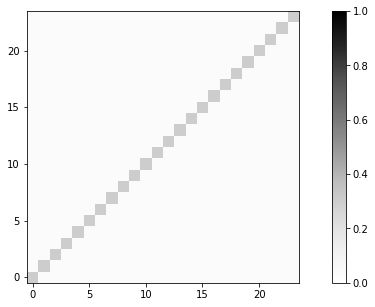

In [14]:
# make the transition probabilities:
trans_probs = fmp.make_regular_transition_probs(10.)

plt.imshow(trans_probs, origin='lower', cmap="Greys", vmin=0, vmax=1);
plt.colorbar();

### Initial Probabilities

Here, don't assume anything a priori. So, $C$ is simply a uniform probability vector:

In [15]:
init_probs = np.ones(24) /24 
print(init_probs)

[0.04166667 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667
 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667
 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667
 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667]


### Emission Probabilities

Finally, we need Matrix $B$:
- For a given chord (state), what is the probability distribution amongst the different possible observations?
- It is not just 1-1. Confusion can easily happen.
- A particular chord ($\mathbf{C}$) may produce an observation that looks like a $\mathbf{C}$, $\mathbf{Am}$, or $\mathbf{Em}$ template. But it is much more likely to produce $\mathbf{C}$ or $\mathbf{Am}$ than, say $\mathbf{F \sharp}$.

To create $B$, assign probability values by seeing how close one template is to another. Templates that are closer produce a higher probability of observation:

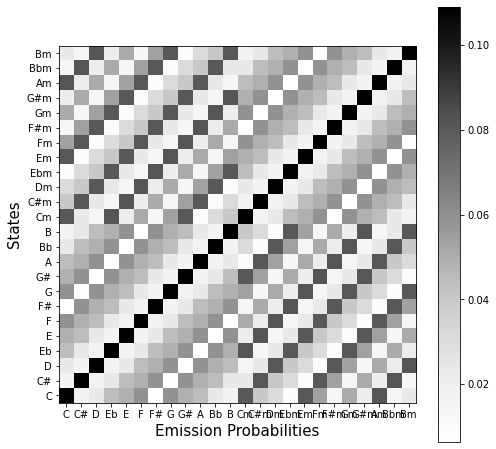

In [16]:
emis_probs = fmp.make_emission_probs(0.7)
plt.figure(figsize=(8,8))
plt.imshow(emis_probs, origin='lower',cmap="Greys")
fmp.chord_template_labels(0)
fmp.chord_template_labels(1)
plt.colorbar();
plt.ylabel('States', fontsize=15)
plt.xlabel('Emission Probabilities', fontsize=15)
plt.show()

## Uncovering the Hidden States

Our model $\Theta$ is now fully defined.

We'll use the python module `hmmlearn` to run the Viterbi algorithm on an observation sequence given our model parameters.

The discrete HMM in hmmlearn is called `MultinomialHMM`.  
Finding the optimal hidden state sequence is done with the `decode()` function.

In [17]:
from hmmlearn import hmm

# initialize the HMM with the number of states
model = hmm.MultinomialHMM(n_components=24)

# set the probabilities
model.transmat_ = trans_probs
model.startprob_ = init_probs
model.emissionprob_ = emis_probs

### Test Example

In [18]:
# create an observation sequence
observations = np.array((0,0,0,1,0,0,9,7,7,7,7,7,7,7))
obs_column = observations.reshape(-1, 1) # must be converted to a column vector

# find the optimal state sequence
est = model.decode(obs_column)[1]

print('observations:', observations)
print('state est   :', est)

observations: [0 0 0 1 0 0 9 7 7 7 7 7 7 7]
state est   : [0 0 0 0 0 0 0 7 7 7 7 7 7 7]


### Song Examples

The Beatles _Let It Be_

Create chromagram features with:
- FFT size: $N=4096$
- Hop size: $H=2048$
- Logarithmic compression factor $\gamma = 1.0$
- Euclidean normalization

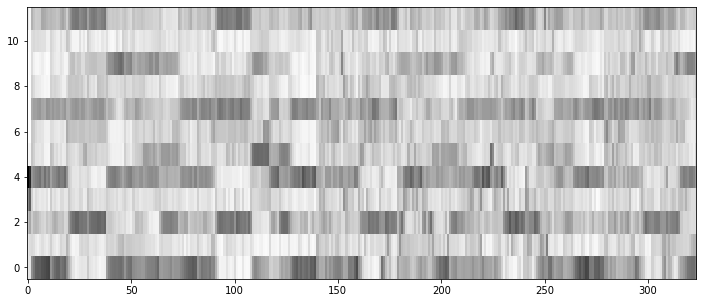

In [19]:
# Test case with Beatles

fs = 22050.
fft_len = 4096
hop_size = fft_len // 2
ff = fs / hop_size

chroma = fmp.make_chromagram(snd1, fs, fft_len, hop_size, gamma=1.)
plt.imshow(chroma, origin='lower', aspect='auto', cmap="Greys");

Map observations (chroma vectors) to the codebook of 24 observations / templates:

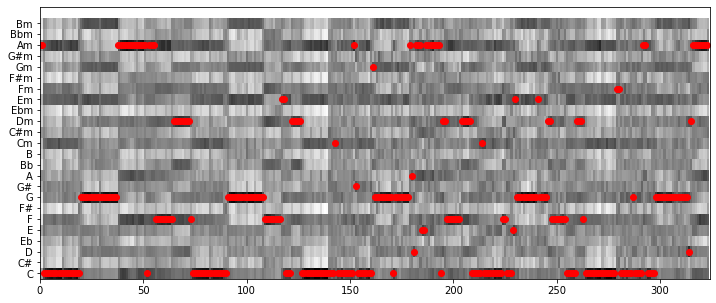

In [26]:
probs = np.dot(triads, chroma)
observations = np.argmax(probs, axis=0)

fmp.plot_matrix_and_points(probs, observations)
fmp.chord_template_labels(0)

This plot is exactly the same as our chord estimating process from last time.

But now, we consider these to be _observations_ of a HMM. So we use them to uncover the hidden states:

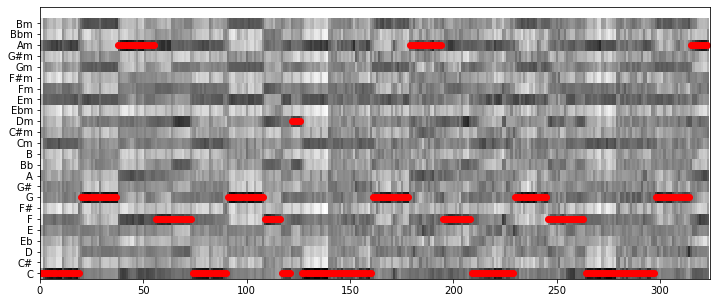

In [21]:
obs_column = observations.reshape(-1, 1)
hmm_estimates = model.decode(obs_column)[1]

fmp.plot_matrix_and_points(probs, hmm_estimates)
fmp.chord_template_labels(0)

Testing against Ground Truth:

In [22]:
ref1 = fmp.load_chord_annotations("audio/beatles_let_it_be.lab", ff)

print(f"template only: {fmp.calc_chord_score(observations, ref1):.3f}")
print(f"HMM estimats:  {fmp.calc_chord_score(hmm_estimates, ref1):.3f}")

template only: 0.783
HMM estimats:  0.929


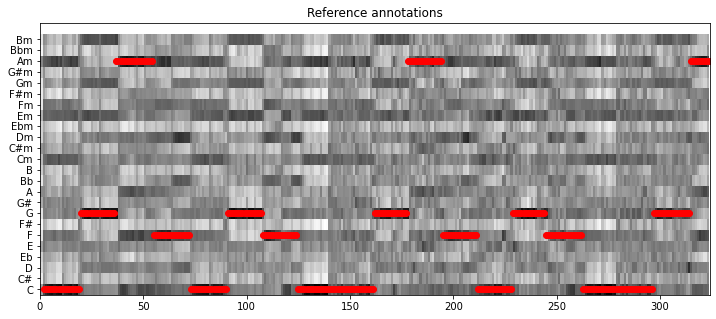

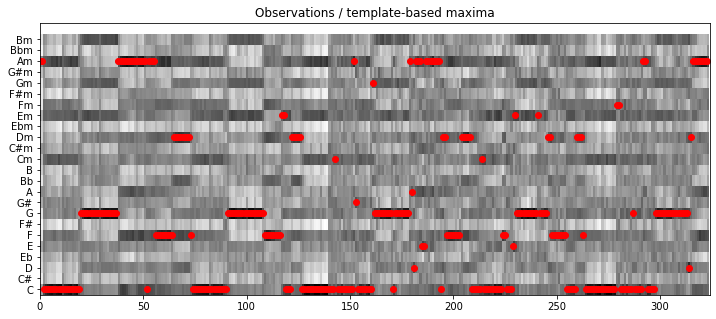

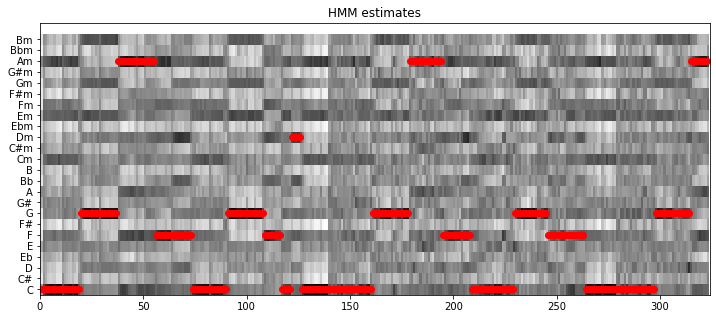

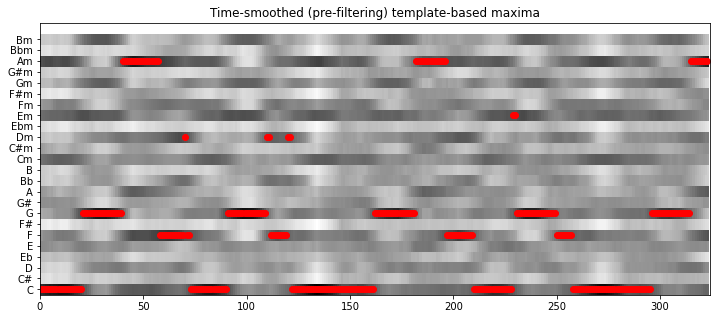

In [23]:
plt.figure()
plt.title('Reference annotations')
fmp.plot_matrix_and_points(probs, ref1)
fmp.chord_template_labels(0)

plt.figure()
plt.title('Observations / template-based maxima')
fmp.plot_matrix_and_points(probs, observations)
fmp.chord_template_labels(0)

plt.figure()
plt.title('HMM estimates')
fmp.plot_matrix_and_points(probs, hmm_estimates)
fmp.chord_template_labels(0)

plt.figure()
plt.title('Time-smoothed (pre-filtering) template-based maxima')
chroma_filt = fmp.temporal_smoothing(chroma, 12)
templates_filt = np.dot(triads, chroma_filt)
estimates_filt = np.argmax(templates_filt, axis=0)
fmp.plot_matrix_and_points(templates_filt, estimates_filt)
fmp.chord_template_labels(0)

In [24]:
def hmm_estimation(chroma, alpha, diag_ratio):
    # emission probabilities
    emis_probs = fmp.make_emission_probs(alpha)

    # transition probabilities:
    trans_probs = fmp.make_regular_transition_probs(diag_ratio)
    
    # initial probabilities:
    init_probs = np.ones(24) / 24.

    # create observations:
    observations = fmp.estimate_chords(chroma, alpha)
    obs_column = observations.reshape(-1, 1)

    # create HMM model
    model = hmm.MultinomialHMM(n_components=24)
    model.transmat_ = trans_probs
    model.startprob_ = init_probs
    model.emissionprob_ = emis_probs
    
    # run HMM model:
    return model.decode(obs_column)[1]

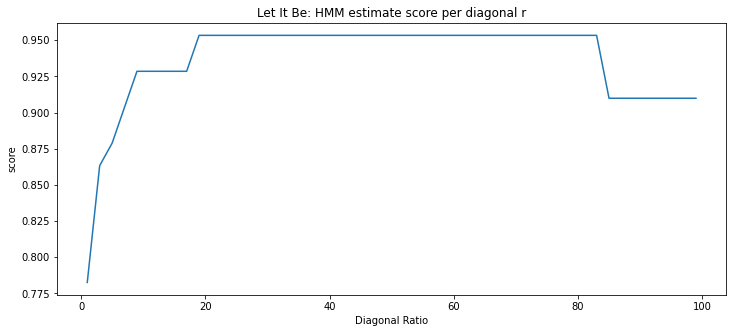

In [25]:
def score_per_diag_r(snd, ref):
    chroma = fmp.make_chromagram(snd, fs, fft_len, hop_size, gamma=1)
    diag_r = np.arange(1, 100, 2)
    score = np.zeros(len(diag_r))
    for i, r in enumerate(diag_r):
        hmm_est = hmm_estimation(chroma, 0.7, r)
        score[i] = fmp.calc_chord_score(hmm_est, ref)
    return diag_r, score

diag_r, score = score_per_diag_r(snd1, ref1)
plt.figure()
plt.plot(diag_r, score)
plt.title('Let It Be: HMM estimate score per diagonal r')
plt.xlabel("Diagonal Ratio")
plt.ylabel("score")
plt.show()